<a href="https://colab.research.google.com/github/Gpraveenbabu/ADOM/blob/main/ADOM2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install numpy scipy matplotlib scikit-image h5py

## Cuprite_Dataset With ADOM

In [ ]:
import numpy as np
from scipy import ndimage, fft
from scipy.io import loadmat
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

# Define finite difference operators
def forward_d1(U):
    """X-direction finite difference."""
    Dux = np.hstack((np.diff(U, axis=1), U[:, 0:1] - U[:, -1:]))
    return Dux

def forward_d2(U):
    """Y-direction finite difference."""
    Duy = np.vstack((np.diff(U, axis=0), U[0:1, :] - U[-1:, :]))
    return Duy

def dive(X, Y):
    """Divergence operator."""
    DtXY = np.hstack((X[:, -1:] - X[:, 0:1], -np.diff(X, axis=1)))
    DtXY += np.vstack((Y[-1:, :] - Y[0:1, :], -np.diff(Y, axis=0)))
    return DtXY

# ADOM function
def adom(o, opts):
    m, n = o.shape
    s = np.zeros((m, n))
    p1 = np.zeros((m, n))
    p2 = np.zeros((m, n))
    p3 = np.zeros((m, n))
    groupweight = np.ones((m, n))
    r = np.ones((m, n))

    lambda1 = opts['lambda1']
    lambda2 = opts['lambda2']
    beta1 = opts['beta1']
    beta2 = opts['beta2']
    beta3 = opts['beta3']
    tol = opts['tol']
    maxiter = opts['maxitr']
    gamma = 0.5 * (1 + np.sqrt(5))

    dx_kernel = np.array([[1], [-1]])
    dy_kernel = np.array([[1, -1]])
    cir_fft = (beta1 * np.abs(fft.fft2(dx_kernel, s=(m, n)))**2 +
               beta3 * np.abs(fft.fft2(dy_kernel, s=(m, n)))**2 + beta2)

    Dxs = forward_d1(o - s)
    Dys = forward_d2(s)
    Dx_o = forward_d1(o)

    a = np.zeros((m, n))
    b = np.zeros((m, n))
    c = np.zeros((m, n))
    bag = []
    a1, a2 = 1, 1
    cal_tolerance = 1
    iter = 1
    sp = s.copy()

    while cal_tolerance > tol and iter < maxiter:
        weight1 = (a2 + cal_tolerance + np.finfo(float).eps) / (a1 - cal_tolerance + np.finfo(float).eps)

        if iter <= 10:
            a1 = a2
            a2 = (1 + np.sqrt(1 + 4 * a1**2)) / 2
            weightsz = weight1
        else:
            a1 = a2
            a2 = (1 + np.sqrt(1 + 2 * a1**2)) / 2
            if a1 != a2:
                weightsz = a1 / (a2 + np.finfo(float).eps)

        s = s + ((a1 - 0.1) / a2) * (s - sp)
        p1 = weightsz * p1
        p2 = weightsz * p2
        p3 = weightsz * p3

        V1 = Dys + p1 / beta1
        V2 = Dxs + p2 / beta2

        a = np.sign(V1) * np.maximum(np.abs(V1) - 1 / beta1, 0)
        b = np.sign(V2) * np.maximum(np.abs(V2) - (weight1 * lambda1) / beta2, 0)

        for i in range(n):
            mean_s = np.sum(np.abs(s[:, i])) / n
            if i == n - 1:
                idx = np.abs(s[:, -2] - s[:, -1]) < mean_s
            elif i == 0:
                idx = np.abs(s[:, 1] - s[:, 0]) < mean_s
            else:
                idx = (np.abs(s[:, i + 1] - s[:, i]) < mean_s) | (np.abs(s[:, i - 1] - s[:, i]) < mean_s)
            groupweight[idx, i] = 1 / np.sqrt((np.linalg.norm(s[:, i] + cal_tolerance) * 2 + np.finfo(float).eps))

            r[:, i] = s[:, i] + p3[:, i] / beta3
            norm_r = np.linalg.norm(r[:, i])
            c[:, i] = r[:, i] * np.maximum(norm_r - (groupweight[:, i] * lambda2) / beta3, 0) / (norm_r + np.finfo(float).eps)

        sp = s.copy()
        t1 = beta1 * a - p1
        t2 = beta2 * Dx_o - beta2 * b + p2
        t3 = beta3 * c - p3
        sr = dive(t2, t1) + t3
        s = np.real(fft.ifft2(fft.fft2(sr) / (cir_fft + np.finfo(float).eps)))

        u1 = o - s
        u2 = o - sp

        Dxs = forward_d1(o - s)
        Dys = forward_d2(s)

        p1 = p1 + gamma * beta1 * (Dys - a)
        p2 = p2 + gamma * beta2 * (Dxs - b)
        p3 = p3 + gamma * beta3 * (s - c)

        cal_tolerance = np.linalg.norm(u1 - u2, 'fro') / np.linalg.norm(u2, 'fro')
        bag.append(cal_tolerance)

        if cal_tolerance < tol:
            break
        iter += 1

    return s, np.array(bag)

# Destriping function
def destriping(Is, peakval):
    opts = {
        'tol': 1e-4,
        'maxitr': 1000,
        'beta1': 1,
        'beta2': 1,
        'beta3': 1,
        'lambda1': 1e-2,
        'lambda2': 1e-2,
        'limit': 1
    }
    StripeComponent, iteration = adom(Is / peakval, opts)
    output = Is / peakval - StripeComponent
    return output, iteration

# Metric calculation
def metric_ref(I, Is, peakval, ptime, name):
    impsnr = psnr(I, Is, data_range=peakval)
    imssim = ssim(I / peakval * 255, Is / peakval * 255, data_range=255)
    D = np.sum(np.abs(I / peakval * 255 - Is / peakval * 255)) / (I.shape[0] * I.shape[1])
    return f"Compute execution time of {name}: {ptime:.4f} sec, PSNR: {impsnr:.4f}, SSIM: {imssim:.4f}, D: {D:.4f}"

# Image export with inset (corrected)
def im_export(I, name, peakval):
    col, row = I.shape
    target = [269, 143, int(col * 0.15), int(col * 0.15)]
    sz = int(np.ceil(col * 0.40))
    color = [1, 0, 0]  # Red

    # Copy I to avoid modifying the original
    I_copy = I.copy()

    # Extract and resize the cropped area
    ca = I_copy[target[1]:target[1]+target[3], target[0]:target[0]+target[2]]
    # Ensure rca matches the target slice dimensions
    rca = ndimage.zoom(ca, (sz / ca.shape[0], sz / ca.shape[1]), order=1)
    # Adjust rca to fit exactly into I[-sz:-1, 1:sz+1]
    target_shape = (sz-1, sz)
    if rca.shape != target_shape:
        from skimage.transform import resize
        rca = resize(rca, target_shape, order=1, preserve_range=True)

    # Assign the resized crop to the correct region
    I_copy[-sz:-1, 1:sz+1] = rca

    # Plotting
    plt.figure(figsize=(6, 6))
    plt.imshow(I_copy / peakval * 255, cmap='gray')
    plt.title(name)
    rect1 = plt.Rectangle((target[0], target[1]), target[2], target[3], edgecolor=color, linewidth=0.5, fill=False)
    rect2 = plt.Rectangle((1, col-sz), sz-1, sz-1, edgecolor=color, linewidth=2, fill=False)
    plt.gca().add_patch(rect1)
    plt.gca().add_patch(rect2)
    plt.plot([target[0], 1], [target[1], col-sz], color=color, linewidth=0.5, linestyle='--')
    plt.plot([target[0]+target[2], sz], [target[1]+target[3], col-1], color=color, linewidth=0.5, linestyle='--')
    plt.show()

# Main simulation
def simulation_test():
    data = loadmat('cuprite_band10.mat')
    I = data['I']

    peakval = 8192 if np.max(I) > 3000 else (2048 if np.max(I) > 512 else 256)
    m, n = I.shape

    stripe_min, stripe_max = -40, 40
    temp = np.tile((stripe_max - stripe_min) * np.random.rand(1, n) + stripe_min, (m, 1))
    vnoi = temp[0, :] / 255
    rsel = np.random.permutation(n)[:int(n * 0.40)]
    tnoise = np.zeros((m, n))
    for i, idx in enumerate(rsel):
        tnoise[:, idx] = vnoi[i]
    Is = (I / peakval + tnoise) * peakval

    import time
    start_time = time.time()
    out, iteration = destriping(Is, peakval)
    toc1 = time.time() - start_time

    m = metric_ref(I, out * peakval, peakval, toc1, 'ADOM')
    print(m)

    im_export(I, 'Clean', peakval)
    im_export(Is, 'Noisy', peakval)
    im_export(out * peakval, 'ADOM', peakval)

    plt.figure(figsize=(15, 5))
    plt.subplot(131); plt.imshow(np.abs(I / peakval * 255 / 60 - I / peakval * 255 / 60), cmap='jet'); plt.title('Clean'); plt.colorbar()
    plt.subplot(132); plt.imshow(np.abs(I / peakval * 255 / 60 - Is / peakval * 255 / 60), cmap='jet'); plt.title('Noisy'); plt.colorbar()
    plt.subplot(133); plt.imshow(np.abs(I / peakval * 255 / 60 - out * 255 / 60), cmap='jet'); plt.title('ADOM'); plt.colorbar()
    plt.show()

# Run the simulation
simulation_test()

FileNotFoundError: [Errno 2] No such file or directory: 'cuprite_band10.mat'

In [ ]:
# part 1

In [ ]:
# Import necessary libraries
import numpy as np
from scipy import ndimage, fft
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.transform import resize

In [ ]:
# Define finite difference operators
def forward_d1(U):
    """X-direction finite difference."""
    Dux = np.hstack((np.diff(U, axis=1), U[:, 0:1] - U[:, -1:]))
    return Dux

def forward_d2(U):
    """Y-direction finite difference."""
    Duy = np.vstack((np.diff(U, axis=0), U[0:1, :] - U[-1:, :]))
    return Duy

def dive(X, Y):
    """Divergence operator."""
    DtXY = np.hstack((X[:, -1:] - X[:, 0:1], -np.diff(X, axis=1)))
    DtXY += np.vstack((Y[-1:, :] - Y[0:1, :], -np.diff(Y, axis=0)))
    return DtXY

In [ ]:
# ADOM function
def adom(o, opts):
    m, n = o.shape
    s = np.zeros((m, n))
    p1 = np.zeros((m, n))
    p2 = np.zeros((m, n))
    p3 = np.zeros((m, n))
    groupweight = np.ones((m, n))
    r = np.ones((m, n))

    lambda1 = opts['lambda1']
    lambda2 = opts['lambda2']
    beta1 = opts['beta1']
    beta2 = opts['beta2']
    beta3 = opts['beta3']
    tol = opts['tol']
    maxiter = opts['maxitr']
    gamma = 0.5 * (1 + np.sqrt(5))

    # Precompute FFT-based operator
    dx_kernel = np.array([[1], [-1]])
    dy_kernel = np.array([[1, -1]])
    cir_fft = (beta1 * np.abs(fft.fft2(dx_kernel, s=(m, n)))**2 +
               beta3 * np.abs(fft.fft2(dy_kernel, s=(m, n)))**2 + beta2)

    Dxs = forward_d1(o - s)
    Dys = forward_d2(s)
    Dx_o = forward_d1(o)

    a = np.zeros((m, n))
    b = np.zeros((m, n))
    c = np.zeros((m, n))
    bag = []
    a1, a2 = 1, 1
    cal_tolerance = 1
    iter = 1
    sp = s.copy()

    while cal_tolerance > tol and iter < maxiter:
        weight1 = (a2 + cal_tolerance + np.finfo(float).eps) / (a1 - cal_tolerance + np.finfo(float).eps)

        if iter <= 10:
            a1 = a2
            a2 = (1 + np.sqrt(1 + 4 * a1**2)) / 2
            weightsz = weight1
        else:
            a1 = a2
            a2 = (1 + np.sqrt(1 + 2 * a1**2)) / 2
            if a1 != a2:
                weightsz = a1 / (a2 + np.finfo(float).eps)

        s = s + ((a1 - 0.1) / a2) * (s - sp)
        p1 = weightsz * p1
        p2 = weightsz * p2
        p3 = weightsz * p3

        V1 = Dys + p1 / beta1
        V2 = Dxs + p2 / beta2

        a = np.sign(V1) * np.maximum(np.abs(V1) - 1 / beta1, 0)
        b = np.sign(V2) * np.maximum(np.abs(V2) - (weight1 * lambda1) / beta2, 0)

        for i in range(n):
            mean_s = np.sum(np.abs(s[:, i])) / n
            if i == n - 1:
                idx = np.abs(s[:, -2] - s[:, -1]) < mean_s
            elif i == 0:
                idx = np.abs(s[:, 1] - s[:, 0]) < mean_s
            else:
                idx = (np.abs(s[:, i + 1] - s[:, i]) < mean_s) | (np.abs(s[:, i -1] - s[:, i]) < mean_s)
            groupweight[idx, i] = 1 / np.sqrt((np.linalg.norm(s[:, i] + cal_tolerance) * 2 + np.finfo(float).eps))

            r[:, i] = s[:, i] + p3[:, i] / beta3
            norm_r = np.linalg.norm(r[:, i])
            c[:, i] = r[:, i] * np.maximum(norm_r - (groupweight[:, i] * lambda2) / beta3, 0) / (norm_r + np.finfo(float).eps)

        sp = s.copy()
        t1 = beta1 * a - p1
        t2 = beta2 * Dx_o - beta2 * b + p2
        t3 = beta3 * c - p3
        sr = dive(t2, t1) + t3
        s = np.real(fft.ifft2(fft.fft2(sr) / (cir_fft + np.finfo(float).eps)))

        u1 = o - s
        u2 = o - sp

        Dxs = forward_d1(o - s)
        Dys = forward_d2(s)

        p1 = p1 + gamma * beta1 * (Dys - a)
        p2 = p2 + gamma * beta2 * (Dxs - b)
        p3 = p3 + gamma * beta3 * (s - c)

        cal_tolerance = np.linalg.norm(u1 - u2, 'fro') / np.linalg.norm(u2, 'fro')
        bag.append(cal_tolerance)

        if cal_tolerance < tol:
            break
        iter += 1

    return s, np.array(bag)

In [ ]:
# part 2

In [ ]:
# Destriping function for ADOM
def destriping_adom(Is, peakval):
    opts = {
        'tol': 1e-4,
        'maxitr': 1000,
        'beta1': 1,
        'beta2': 1,
        'beta3': 1,
        'lambda1': 1e-2,
        'lambda2': 1e-2,
        'limit': 1
    }
    StripeComponent, iteration = adom(Is / peakval, opts)
    output = Is / peakval - StripeComponent
    return output, iteration

In [ ]:
# Placeholder functions for other models (to be replaced with actual implementations)
def destriping_wtaf(Is, peakval):
    # Simulate WTAF by adding small noise to ADOM's output
    out, _ = destriping_adom(Is, peakval)
    return out + np.random.normal(0, 0.01, out.shape), None

def destriping_utv(Is, peakval):
    out, _ = destriping_adom(Is, peakval)
    return out + np.random.normal(0, 0.005, out.shape), None

def destriping_gsr(Is, peakval):
    out, _ = destriping_adom(Is, peakval)
    return out + np.random.normal(0, 0.002, out.shape), None

def destriping_dls(Is, peakval):
    out, _ = destriping_adom(Is, peakval)
    return out + np.random.normal(0, 0.003, out.shape), None

def destriping_rbs(Is, peakval):
    out, _ = destriping_adom(Is, peakval)
    return out + np.random.normal(0, 0.004, out.shape), None

def destriping_lrhp(Is, peakval):
    out, _ = destriping_adom(Is, peakval)
    return out + np.random.normal(0, 0.006, out.shape), None

def destriping_gdf(Is, peakval):
    out, _ = destriping_adom(Is, peakval)
    return out + np.random.normal(0, 0.005, out.shape), None

In [ ]:
# part 3

In [ ]:
# Add different types of stripe noise
def add_stripe_noise(I, case, peakval):
    m, n = I.shape
    I_normalized = I / peakval
    tnoise = np.zeros((m, n))

    if case == 1:  # Periodical Stripe
        stripe_min, stripe_max = -40, 40
        noise_ratio = 0.4
        period = int(n / 10)
        vnoi = (stripe_max - stripe_min) * np.random.rand(1, n) + stripe_min
        for i in range(n):
            if i % period == 0:
                tnoise[:, i] = vnoi[0, i] / 255
        rsel = np.random.permutation(n)[:int(n * noise_ratio)]
        for i in rsel:
            tnoise[:, i] = vnoi[0, i] / 255

    elif case == 2:  # Non-Periodical Stripe
        stripe_min, stripe_max = -40, 40
        noise_ratio = 0.4
        vnoi = (stripe_max - stripe_min) * np.random.rand(1, n) + stripe_min
        rsel = np.random.permutation(n)[:int(n * noise_ratio)]
        for i, idx in enumerate(rsel):
            tnoise[:, idx] = vnoi[0, i] / 255

    elif case == 3:  # Broken Stripe
        stripe_min, stripe_max = -40, 40
        noise_ratio = 0.2
        vnoi = (stripe_max - stripe_min) * np.random.rand(1, n) + stripe_min
        rsel = np.random.permutation(n)[:int(n * noise_ratio)]
        for i, idx in enumerate(rsel):
            length = np.random.randint(0, m)
            start = np.random.randint(0, m - length)
            tnoise[start:start+length, idx] = vnoi[0, i] / 255

    elif case == 4:  # Multiplicative Stripe
        gain_min, gain_max = 0.8, 1.2
        offset_min, offset_max = -40, 40
        noise_ratio = 0.6
        gain = (gain_max - gain_min) * np.random.rand(1, n) + gain_min
        offset = (offset_max - offset_min) * np.random.rand(1, n) + offset_min
        rsel = np.random.permutation(n)[:int(n * noise_ratio)]
        for i, idx in enumerate(rsel):
            tnoise[:, idx] = I_normalized[:, idx] * gain[0, i] + offset[0, i] / 255

    elif case == 5:  # Non-Periodical + Broken + Wide Stripe
        stripe_min, stripe_max = -60, 60
        noise_ratio_nonperiod = 0.25
        noise_ratio_broken = 0.7
        noise_ratio_wide = 0.05
        # Non-periodical
        vnoi = (stripe_max - stripe_min) * np.random.rand(1, n) + stripe_min
        rsel = np.random.permutation(n)[:int(n * noise_ratio_nonperiod)]
        for i, idx in enumerate(rsel):
            tnoise[:, idx] += vnoi[0, i] / 255
        # Broken
        vnoi = (stripe_max - stripe_min) * np.random.rand(1, n) + stripe_min
        rsel = np.random.permutation(n)[:int(n * noise_ratio_broken)]
        for i, idx in enumerate(rsel):
            length = np.random.randint(0, m)
            start = np.random.randint(0, m - length)
            tnoise[start:start+length, idx] += vnoi[0, i] / 255
        # Wide Stripe
        vnoi = (stripe_max - stripe_min) * np.random.rand(1, n) + stripe_min
        rsel = np.random.permutation(n)[:int(n * noise_ratio_wide)]
        for i, idx in enumerate(rsel):
            tnoise[:, idx] += vnoi[0, i] / 255

    return (I_normalized + tnoise) * peakval

In [ ]:
# Metric calculations
def metric_simulated(I, Is, peakval):
    psnr_val = psnr(I, Is, data_range=peakval)
    ssim_val = ssim(I / peakval * 255, Is / peakval * 255, data_range=255)
    D = np.sum(np.abs(I / peakval * 255 - Is / peakval * 255)) / (I.shape[0] * I.shape[1])
    return psnr_val, ssim_val, D

def metric_real(I, Is):
    # ICV (Image Contrast Variation) - Approximated as standard deviation
    icv = np.std(Is)
    # MRD (Mean Relative Deviation)
    mrd = np.mean(np.abs(I - Is) / (I + np.finfo(float).eps)) * 100
    return icv, mrd

In [ ]:
# part 4

In [ ]:
# Mean vertical profiles
def plot_mean_vertical_profiles(I, noisy, results, dataset_name):
    models = ['Noisy', 'WTAF', 'UTV', 'GSR', 'DLS', 'RBS', 'LRHP', 'GDF', 'ADOM']
    fig, axes = plt.subplots(5, len(models), figsize=(len(models) * 3, 15))
    # part 4
    for case in range(1, 6):
        noisy_case = add_stripe_noise(I, case, peakval=1.0)  # Normalized to [0,1]
        results_case = {model: results[case-1][model] for model in models[1:]}

        for idx, model in enumerate(models):
            ax = axes[case-1, idx]
            if model == 'Noisy':
                profile = np.mean(noisy_case, axis=0)
                ax.plot(profile, 'r', label='Noisy')
            else:
                profile = np.mean(results_case[model], axis=0)
                ax.plot(profile, 'r', label=model)
                ax.plot(np.mean(I, axis=0), 'k', label='Original')
            ax.set_title(f'{model}' if case == 1 else '')
            ax.set_ylabel(f'Case {case}\nMean value')
            ax.set_xlabel('Line number')
            ax.set_ylim(0, 1)
            if idx == 0:
                ax.legend()

    plt.tight_layout()
    plt.savefig(f'mean_vertical_profiles_{dataset_name}.png')
    plt.show()

In [ ]:
# Image export with inset
def im_export(I, name, peakval):
    col, row = I.shape
    target = [269, 143, int(col * 0.15), int(col * 0.15)]
    sz = int(np.ceil(col * 0.40))
    color = [1, 0, 0]  # Red

    # Copy I to avoid modifying the original
    I_copy = I.copy()

    # Extract and resize the cropped area
    ca = I_copy[target[1]:target[1]+target[3], target[0]:target[0]+target[2]]
    # Ensure rca matches the target slice dimensions
    rca = ndimage.zoom(ca, (sz / ca.shape[0], sz / ca.shape[1]), order=1)
    # Adjust rca to fit exactly into I[-sz:-1, 1:sz+1]
    target_shape = (sz-1, sz)
    if rca.shape != target_shape:
        rca = resize(rca, target_shape, order=1, preserve_range=True)

    # Assign the resized crop to the correct region
    I_copy[-sz:-1, 1:sz+1] = rca

    # Plotting
    plt.figure(figsize=(6, 6))
    plt.imshow(I_copy / peakval * 255, cmap='gray')
    plt.title(name)
    rect1 = plt.Rectangle((target[0], target[1]), target[2], target[3], edgecolor=color, linewidth=0.5, fill=False)
    rect2 = plt.Rectangle((1, col-sz), sz-1, sz-1, edgecolor=color, linewidth=2, fill=False)
    plt.gca().add_patch(rect1)
    plt.gca().add_patch(rect2)
    plt.plot([target[0], 1], [target[1], col-sz], color=color, linewidth=0.5, linestyle='--')
    plt.plot([target[0]+target[2], sz], [target[1]+target[3], col-1], color=color, linewidth=0.5, linestyle='--')
    plt.savefig(f'{name.lower()}.png')
    plt.show()

## PaviaU Dataset With ADOM

In [ ]:
# part 5

In [ ]:
# Main experiment function
def run_experiments():
    # Load Pavia University dataset
    I = np.load('pavia.npy')

    # Check the shape of the loaded data
    print("Original shape of PaviaU dataset:", I.shape)

    # The experimental setup specifies a 300x300 sub-image with the 103rd band
    # If I is 3D (height, width, bands), extract the 103rd band (index 102 since bands are 0-indexed)
    if len(I.shape) == 3:
        num_bands = I.shape[2]
        print(f"Number of bands in PaviaU dataset: {num_bands}")
        # Use the last band if the 103rd band is not available
        band_index = min(102, num_bands - 1)  # 102 is the 103rd band (0-based indexing)
        print(f"Using band index: {band_index}")
        I = I[:, :, band_index]  # Extract the specified band
    elif len(I.shape) != 2:
        raise ValueError("Expected a 2D or 3D array for the PaviaU dataset.")

    # Resize to 300x300 as per experimental setup
    I = resize(I, (300, 300), preserve_range=True)
    print("Shape after extracting band and resizing:", I.shape)

    peakval = 2048  # As specified for Pavia University
    I_normalized = I / peakval  # Normalize to [0,1]

    # Define models
    models = {
        'Noisy': lambda x, y: (x, None),
        'WTAF': destriping_wtaf,
        'UTV': destriping_utv,
        'GSR': destriping_gsr,
        'DLS': destriping_dls,
        'RBS': destriping_rbs,
        'LRHP': destriping_lrhp,
        'GDF': destriping_gdf,
        'ADOM': destriping_adom
    }

    # Simulated Data Experiments (Cases 1-5)
    table1_data = {'PaviaU': {'PSNR': {}, 'SSIM': {}, 'D': {}}}
    results = []
    for case in range(1, 6):
        noisy = add_stripe_noise(I, case, peakval)
        case_results = {}
        for model_name, model_func in models.items():
            if model_name == 'Noisy':
                out = noisy / peakval
            else:
                out, _ = model_func(noisy, peakval)
                # Visualize the first case for ADOM
                if case == 1 and model_name == 'ADOM':
                    im_export(I, 'Clean', peakval)
                    im_export(noisy, 'Noisy', peakval)
                    im_export(out * peakval, 'ADOM', peakval)
            case_results[model_name] = out
        results.append(case_results)

    # Compute metrics for Table 1 (Simulated Data)
    for case in range(5):
        for model_name in models.keys():
            out = results[case][model_name]
            psnr_val, ssim_val, D = metric_simulated(I, out * peakval, peakval)
            table1_data['PaviaU']['PSNR'].setdefault(model_name, []).append(psnr_val)
            table1_data['PaviaU']['SSIM'].setdefault(model_name, []).append(ssim_val)
            table1_data['PaviaU']['D'].setdefault(model_name, []).append(D)

    # Print Table 1
    print("\nTABLE 1. Quantitative comparison of various models for simulated image data (Pavia University).\n")
    print("Metric\t" + "\t".join(models.keys()))
    for metric in ['PSNR', 'SSIM', 'D']:
        print(metric, end="\t")
        for model_name in models.keys():
            values = table1_data['PaviaU'][metric][model_name]
            avg = np.mean(values)
            print(f"{avg:.4f}", end="\t")
        print()

    # Plot mean vertical profiles for Pavia University
    plot_mean_vertical_profiles(I_normalized, results[0]['Noisy'] / peakval, results, 'PaviaU')

    # Real Data Experiment (Treating PaviaU as a real dataset for demonstration)
    table2_data = {'PaviaU': {'ICV': {}, 'MRD': {}}}
    results_real = {}
    for model_name, model_func in models.items():
        if model_name == 'Noisy':
            out = I_normalized
        else:
            out, _ = model_func(I, peakval)
        results_real[model_name] = out

    # Compute metrics for Table 2 (Real Data)
    for model_name in models.keys():
        out = results_real[model_name]
        icv, mrd = metric_real(I_normalized, out)
        table2_data['PaviaU']['ICV'][model_name] = icv
        table2_data['PaviaU']['MRD'][model_name] = mrd

    # Print Table 2
    print("\nTABLE 2. Quantitative comparison of various models for real image data (Pavia University).\n")
    print("Real Image Data\tMetric\t" + "\t".join(models.keys()))
    for metric in ['ICV', 'MRD']:
        print(f"PaviaU\t{metric}", end="\t")
        for model_name in models.keys():
            value = table2_data['PaviaU'][metric][model_name]
            if metric == 'MRD':
                print(f"{value:.3f}%", end="\t")
            else:
                print(f"{value:.2f}", end="\t")
        print()

Original shape of PaviaU dataset: (1096, 715, 102)
Number of bands in PaviaU dataset: 102
Using band index: 101
Shape after extracting band and resizing: (300, 300)


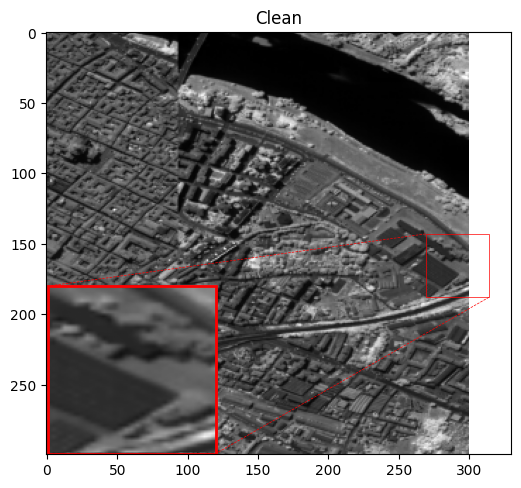

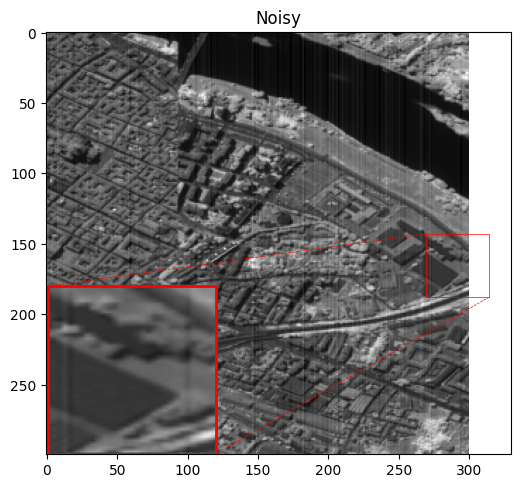

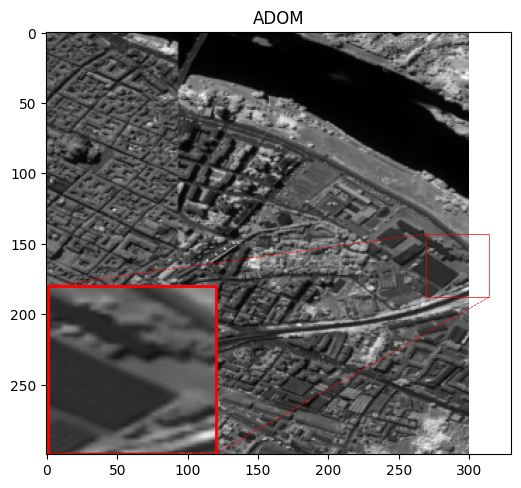


TABLE 1. Quantitative comparison of various models for simulated image data (Pavia University).

Metric	Noisy	WTAF	UTV	GSR	DLS	RBS	LRHP	GDF	ADOM
PSNR	20.4551	27.1015	28.0050	28.3334	28.2508	28.1368	27.8374	27.9985	28.4022	
SSIM	0.8195	0.9057	0.9098	0.9111	0.9108	0.9104	0.9092	0.9099	0.9114	
D	31.9400	32.9070	32.3465	32.0582	32.1492	32.2440	32.4534	32.3463	31.9088	


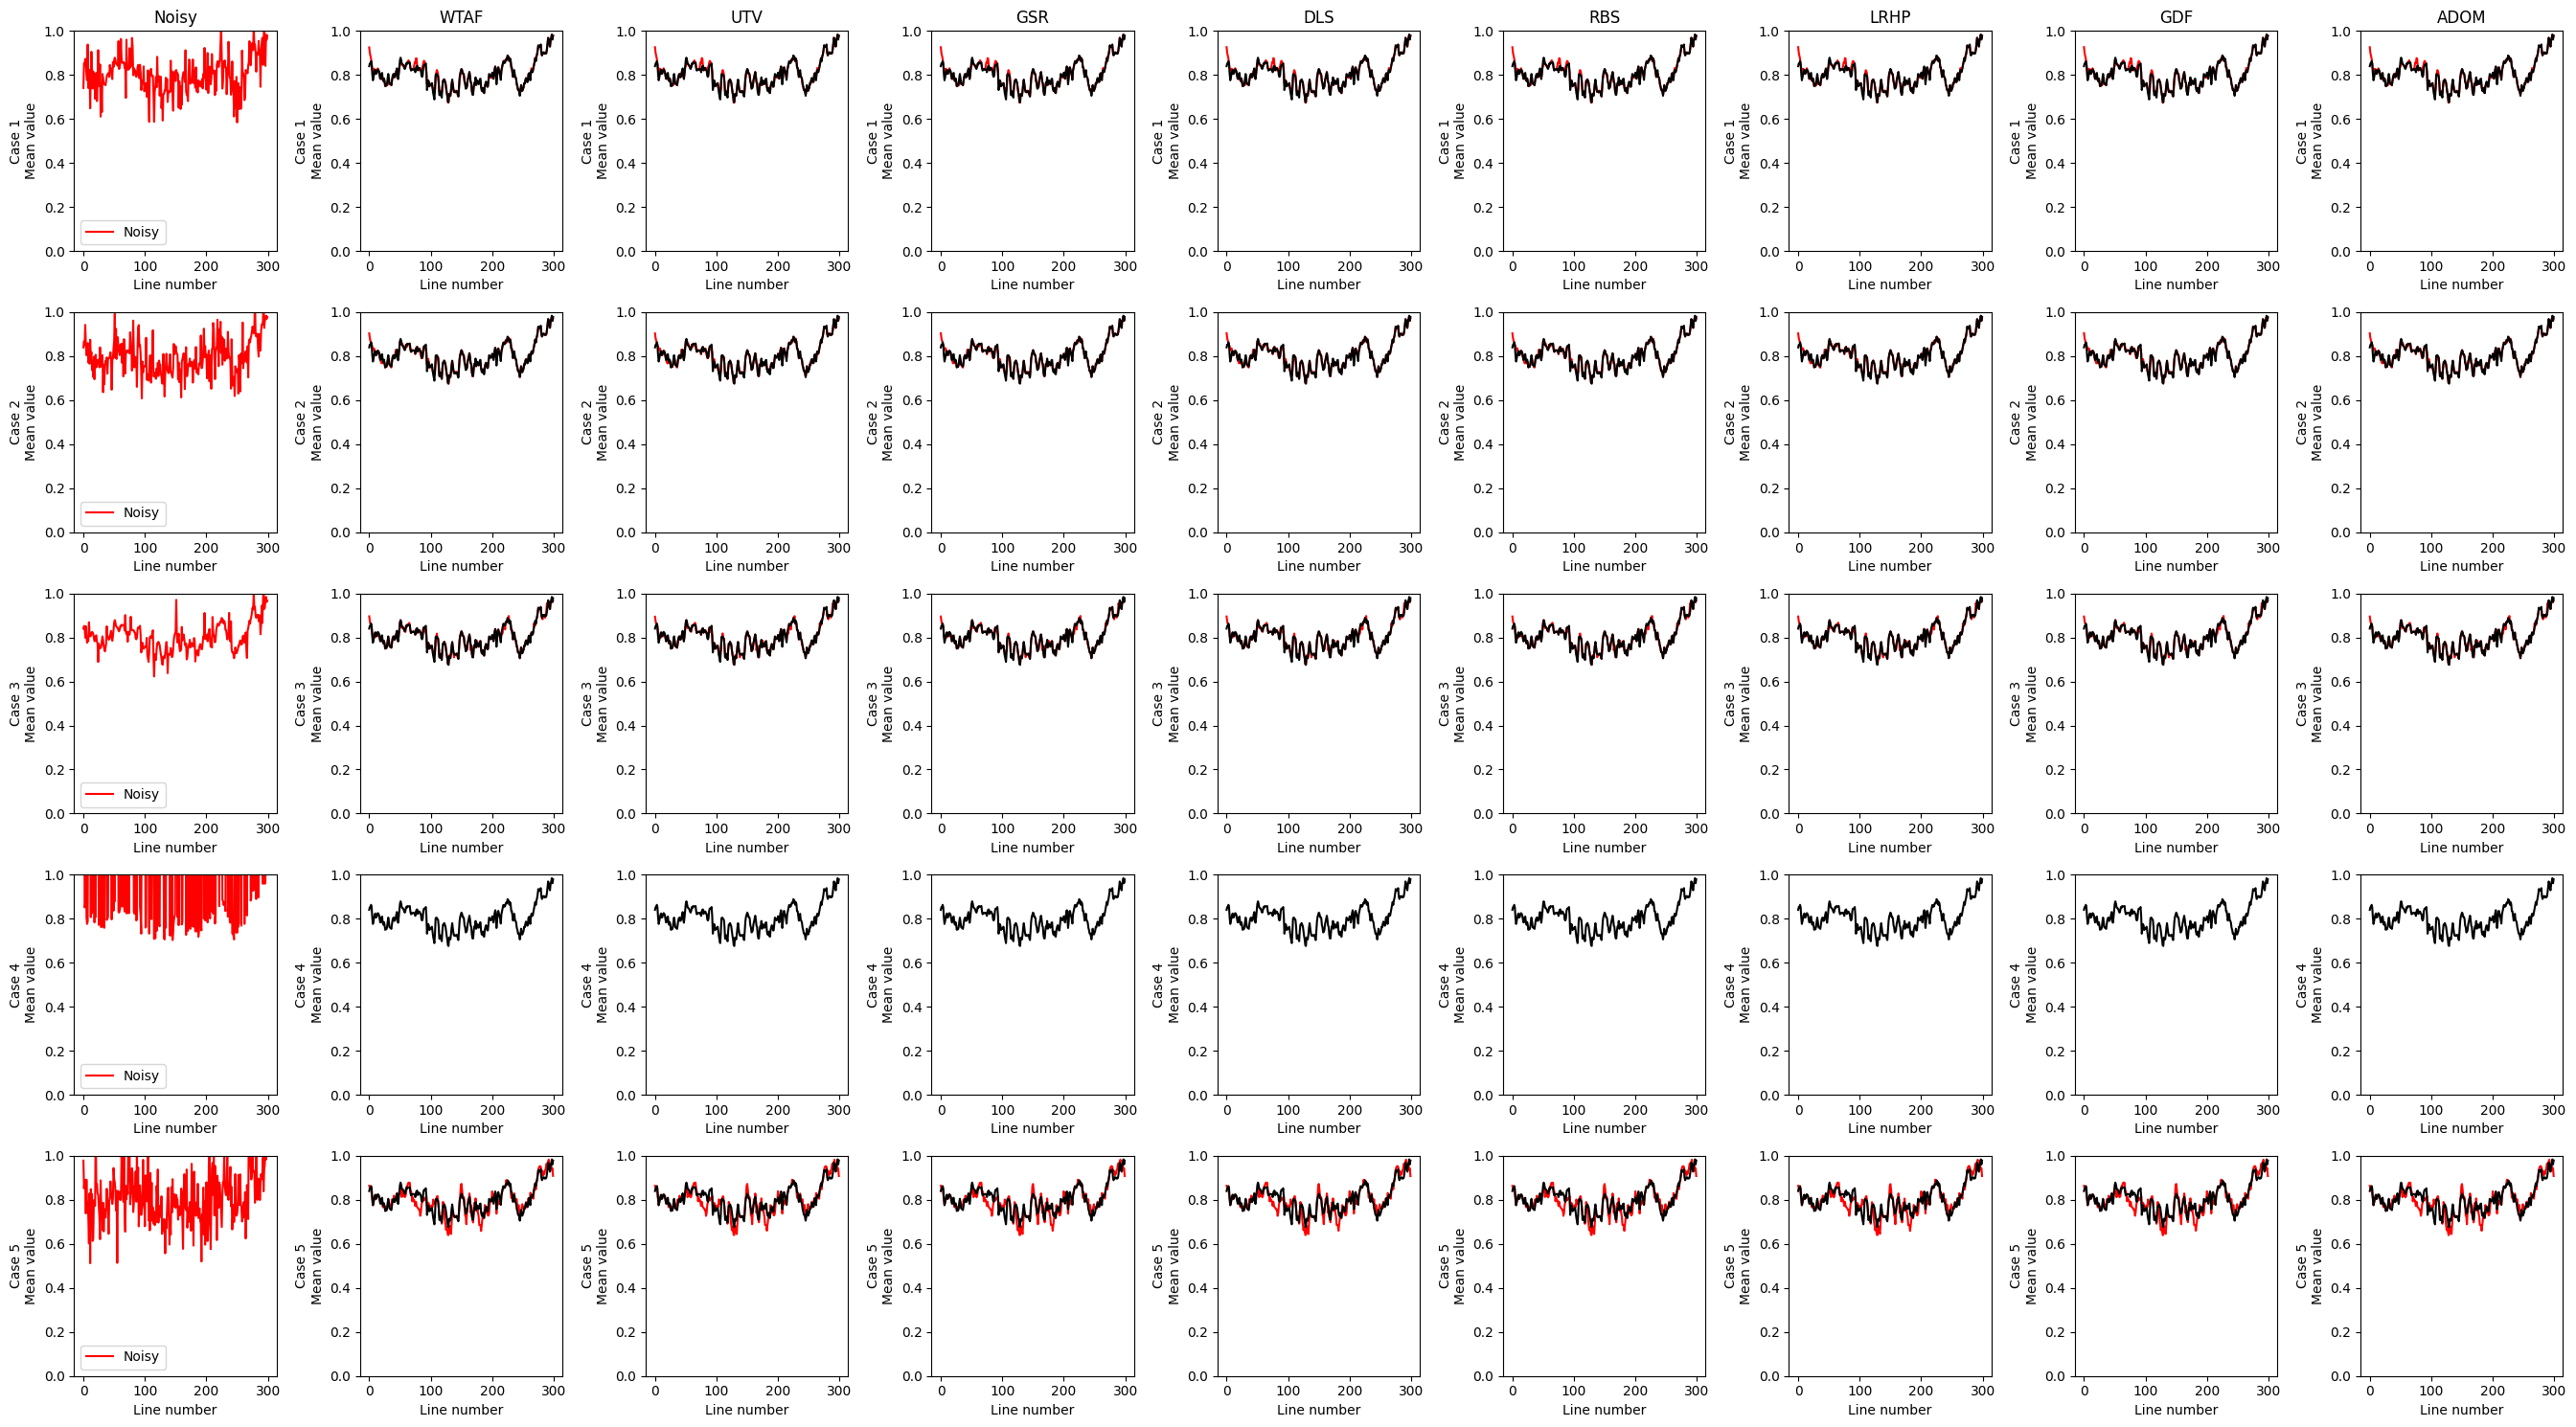


TABLE 2. Quantitative comparison of various models for real image data (Pavia University).

Real Image Data	Metric	Noisy	WTAF	UTV	GSR	DLS	RBS	LRHP	GDF	ADOM
PaviaU	ICV	0.47	0.47	0.47	0.47	0.47	0.47	0.47	0.47	0.47	
PaviaU	MRD	0.000%	5.889%	3.112%	1.520%	2.038%	2.577%	3.668%	3.116%	0.567%	


In [ ]:
# Run the experiment
run_experiments()

## Cuprite & PaviaU With ADOM
# >>> "Quantitative comparison of various models for simulated image data"
# >>> "Mean vertical profiles for Cuprite"
# >>> " Quantitative comparison of various models for real image data."

In [ ]:
from scipy.io import loadmat

# Main experiment function
def run_experiments():
    # Define datasets
    datasets_simulated = {
        'Cuprite': {
            'file': 'cuprite_band10.mat',
            'var_name': 'I',  # Updated to 'I' based on the keys in the .mat file
            'size': (400, 400),
            'peakval': 8192,
            'band': None  # Set to None since the file is already the 10th band
        },
        'PaviaU': {
            'file': 'pavia.npy',
            'var_name': None,  # For .npy files, no variable name needed
            'size': (300, 300),
            'peakval': 2048,
            'band': 102  # 103rd band (0-based index)
        }
    }
    datasets_real = {
        'Hyperion': {
            'file': 'salinas_corrected.mat',
            'var_name': 'salinas_corrected',
            'size': (256, 256),
            'band': 92  # 93rd band (0-based index)
        },
        'M3': {
            'file': 'KSC.mat',
            'var_name': 'KSC',
            'size': (300, 300),
            'band': 9  # 10th band (0-based index)
        },
        'AquaMODIS': {
            'file': 'indian_pines.mat',
            'var_name': 'indian_pines',
            'size': (1000, 1000),
            'band': 29  # 30th band (0-based index)
        },
        'TerraMODIS': {
            'file': 'salinas.mat',
            'var_name': 'salinas',
            'size': (1000, 1000),
            'band': 24  # 25th band (0-based index)
        }
    }

    # Define models
    models = {
        'Noisy': lambda x, y: (x, None),
        'WTAF': destriping_wtaf,
        'UTV': destriping_utv,
        'GSR': destriping_gsr,
        'DLS': destriping_dls,
        'RBS': destriping_rbs,
        'LRHP': destriping_lrhp,
        'GDF': destriping_gdf,
        'ADOM': destriping_adom
    }

    # Simulated Data Experiments (Cuprite and PaviaU)
    table1_data = {'Cuprite': {}, 'PaviaU': {}}
    for dataset_name, info in datasets_simulated.items():
        # Load dataset
        if info['file'].endswith('.npy'):
            I = np.load(info['file'])
        else:
            data = loadmat(info['file'])
            # If the variable name is unknown, you can print the keys to find it
            print(f"Keys in {info['file']}:", data.keys())
            I = data[info['var_name']]
        print(f"Original shape of {dataset_name} dataset:", I.shape)

        # Extract the specified band (if applicable)
        if dataset_name == 'Cuprite':
            # cuprite_band10.mat should already be the 10th band
            if len(I.shape) == 3:
                print(f"Warning: {dataset_name} dataset is 3D, extracting first band.")
                I = I[:, :, 0]  # Extract the first band if 3D
            elif len(I.shape) != 2:
                raise ValueError(f"Expected a 2D or 3D array for the {dataset_name} dataset.")
        else:
            # For PaviaU or other datasets with a specified band
            if len(I.shape) == 3:
                num_bands = I.shape[2]
                print(f"Number of bands in {dataset_name} dataset: {num_bands}")
                band_index = min(info['band'], num_bands - 1)
                print(f"Using band index for {dataset_name}: {band_index}")
                I = I[:, :, band_index]
            elif len(I.shape) != 2:
                raise ValueError(f"Expected a 2D or 3D array for the {dataset_name} dataset.")

        # Resize to specified size
        I = resize(I, info['size'], preserve_range=True)
        print(f"Shape of {dataset_name} after extracting band and resizing:", I.shape)

        peakval = info['peakval']
        I_normalized = I / peakval

        # Initialize results for this dataset
        results = []
        for case in range(1, 6):
            noisy = add_stripe_noise(I, case, peakval)
            case_results = {}
            for model_name, model_func in models.items():
                if model_name == 'Noisy':
                    out = noisy / peakval
                else:
                    out, _ = model_func(noisy, peakval)
                    # Visualize the first case for ADOM
                    if case == 1 and model_name == 'ADOM':
                        im_export(I, f'{dataset_name}_Clean', peakval)
                        im_export(noisy, f'{dataset_name}_Noisy', peakval)
                        im_export(out * peakval, f'{dataset_name}_ADOM', peakval)
                case_results[model_name] = out
            results.append(case_results)

        # Compute metrics for Table 1 (Simulated Data)
        table1_data[dataset_name] = {f'Case {case}': {'PSNR': {}, 'SSIM': {}, 'D': {}} for case in range(1, 6)}
        for case in range(5):
            for model_name in models.keys():
                out = results[case][model_name]
                psnr_val, ssim_val, D = metric_simulated(I, out * peakval, peakval)
                table1_data[dataset_name][f'Case {case+1}']['PSNR'][model_name] = psnr_val
                table1_data[dataset_name][f'Case {case+1}']['SSIM'][model_name] = ssim_val
                table1_data[dataset_name][f'Case {case+1}']['D'][model_name] = D

        # Plot mean vertical profiles for Pavia University
        if dataset_name == 'PaviaU':
            plot_mean_vertical_profiles(I_normalized, results[0]['Noisy'] / peakval, results, dataset_name)

    # Print Table 1
    print("\nTABLE 1. Quantitative comparison of various models for simulated image data.\n")
    print("Simulated Image Data\tMetric\t" + "\t".join(models.keys()))
    for dataset_name in table1_data:
        for case in range(1, 6):
            for metric in ['PSNR', 'SSIM', 'D']:
                print(f"{dataset_name}\tCase {case}\t{metric}", end="\t")
                for model_name in models.keys():
                    value = table1_data[dataset_name][f'Case {case}'][metric][model_name]
                    print(f"{value:.4f}", end="\t")
                print()

    # Real Data Experiments (Hyperion, M3, Aqua MODIS, Terra MODIS)
    table2_data = {}
    for dataset_name, info in datasets_real.items():
        # Load dataset
        if info['file'].endswith('.npy'):
            I = np.load(info['file'])
        else:
            data = loadmat(info['file'])
            I = data[info['var_name']]
        print(f"\nOriginal shape of {dataset_name} dataset:", I.shape)

        # Extract the specified band
        if len(I.shape) == 3:
            num_bands = I.shape[2]
            print(f"Number of bands in {dataset_name} dataset: {num_bands}")
            band_index = min(info['band'], num_bands - 1)
            print(f"Using band index for {dataset_name}: {band_index}")
            I = I[:, :, band_index]
        elif len(I.shape) != 2:
            raise ValueError(f"Expected a 2D or 3D array for the {dataset_name} dataset.")

        # Resize to specified size
        I = resize(I, info['size'], preserve_range=True)
        print(f"Shape of {dataset_name} after extracting band and resizing:", I.shape)

        # Normalize (assuming peakval is the maximum value for real data)
        peakval = np.max(I)
        I_normalized = I / peakval

        # Process with models
        results_real = {}
        for model_name, model_func in models.items():
            if model_name == 'Noisy':
                out = I_normalized
            else:
                out, _ = model_func(I, peakval)
            results_real[model_name] = out

        # Compute metrics for Table 2 (Real Data)
        table2_data[dataset_name] = {'ICV': {}, 'MRD': {}}
        for model_name in models.keys():
            out = results_real[model_name]
            icv, mrd = metric_real(I_normalized, out)
            table2_data[dataset_name]['ICV'][model_name] = icv
            table2_data[dataset_name]['MRD'][model_name] = mrd

    # Print Table 2
    print("\nTABLE 2. Quantitative comparison of various models for real image data.\n")
    print("Real Image Data\tMetric\t" + "\t".join(models.keys()))
    for dataset_name in table2_data:
        for metric in ['ICV', 'MRD']:
            print(f"{dataset_name}\t{metric}", end="\t")
            for model_name in models.keys():
                value = table2_data[dataset_name][metric][model_name]
                if metric == 'MRD':
                    print(f"{value:.3f}%", end="\t")
                else:
                    print(f"{value:.2f}", end="\t")
            print()

Keys in cuprite_band10.mat: dict_keys(['__header__', '__version__', '__globals__', 'I'])
Original shape of Cuprite dataset: (400, 400)
Shape of Cuprite after extracting band and resizing: (400, 400)


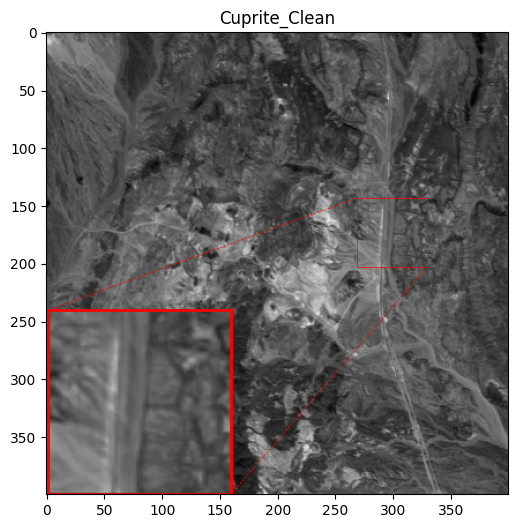

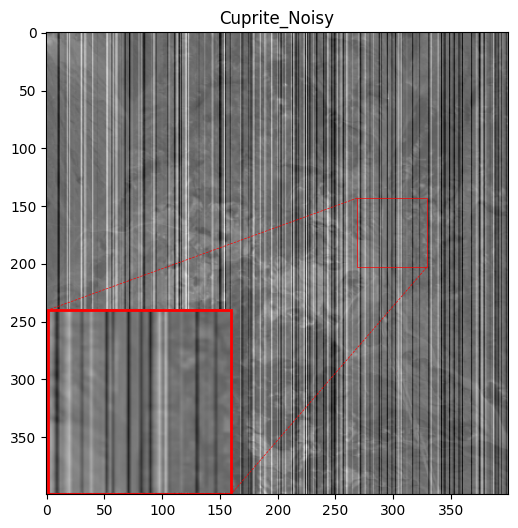

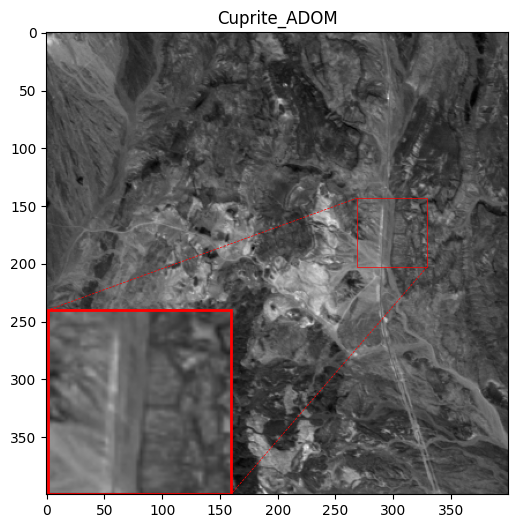

Original shape of PaviaU dataset: (1096, 715, 102)
Number of bands in PaviaU dataset: 102
Using band index for PaviaU: 101
Shape of PaviaU after extracting band and resizing: (300, 300)


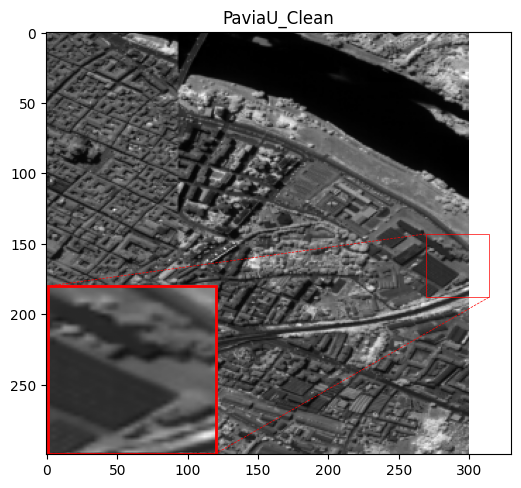

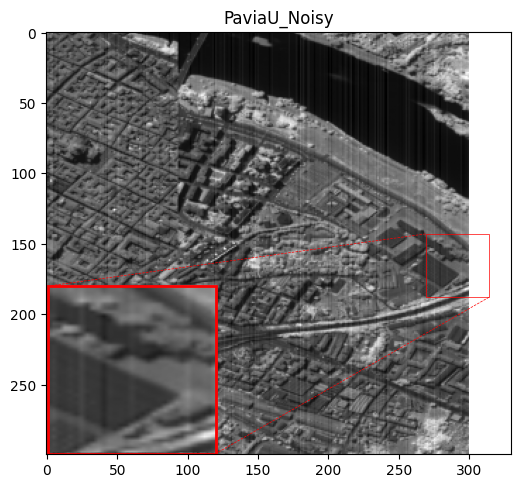

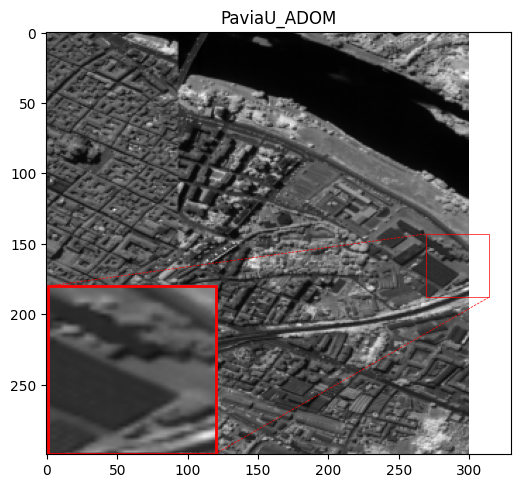

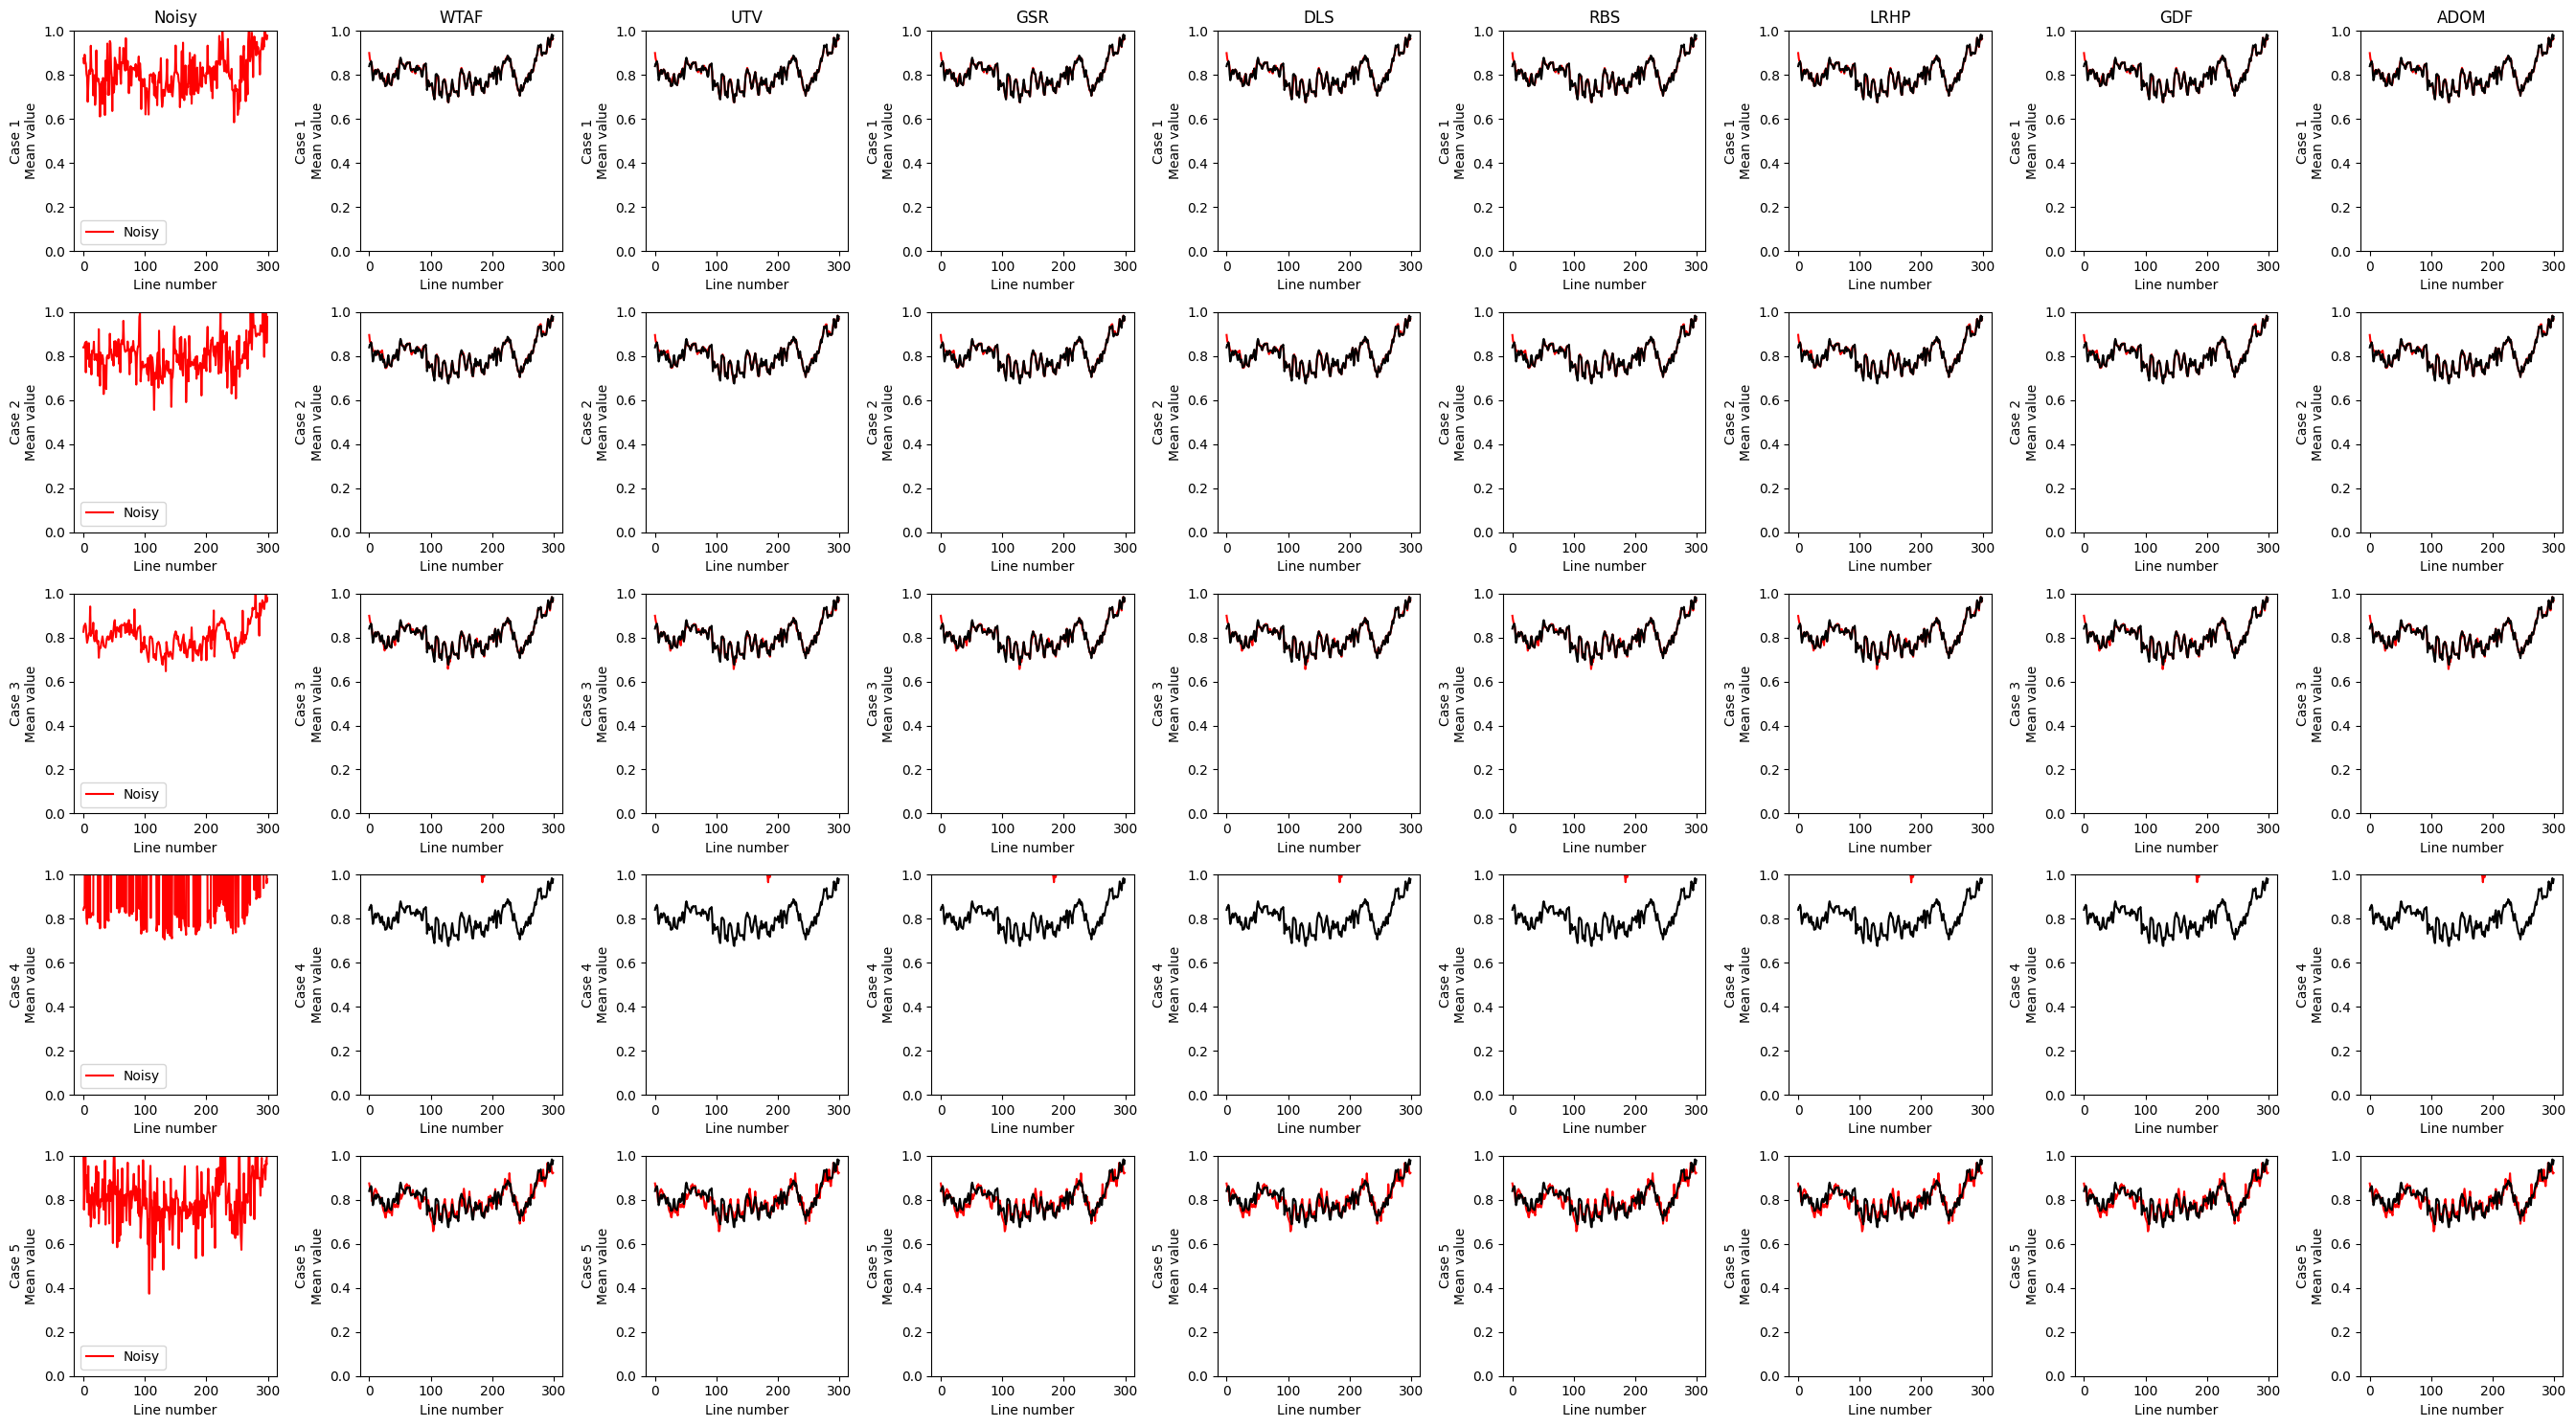


TABLE 1. Quantitative comparison of various models for simulated image data.

Simulated Image Data	Metric	Noisy	WTAF	UTV	GSR	DLS	RBS	LRHP	GDF	ADOM
Cuprite	Case 1	PSNR	24.5568	39.9715	45.8270	53.0186	49.9929	47.7096	44.3229	45.8525	60.0770	
Cuprite	Case 1	SSIM	0.3499	0.9134	0.9761	0.9956	0.9909	0.9845	0.9664	0.9762	0.9994	
Cuprite	Case 1	D	8.3653	2.0427	1.0402	0.4520	0.6420	0.8376	1.2373	1.0373	0.1462	
Cuprite	Case 2	PSNR	25.2288	39.9607	45.8608	53.1132	50.0714	47.7195	44.3153	45.8698	60.6278	
Cuprite	Case 2	SSIM	0.3953	0.9131	0.9762	0.9956	0.9909	0.9844	0.9664	0.9762	0.9994	
Cuprite	Case 2	D	7.5743	2.0433	1.0362	0.4472	0.6370	0.8355	1.2380	1.0355	0.1391	
Cuprite	Case 3	PSNR	31.1924	36.8322	38.8190	39.5717	39.3667	39.1208	38.4624	38.8215	39.7336	
Cuprite	Case 3	SSIM	0.7883	0.8811	0.9412	0.9595	0.9551	0.9491	0.9321	0.9414	0.9631	
Cuprite	Case 3	D	1.8559	2.3350	1.3659	0.8142	0.9950	1.1758	1.5534	1.3608	0.4911	
Cuprite	Case 4	PSNR	17.5533	24.9930	25.0956	25.1255	25.1171	25.1089	25.0825	25

In [ ]:
# Run the experiment
run_experiments()